In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random
from scipy import stats
from sklearn.utils import resample
from statsmodels.stats import power

import matplotlib as mpl
import seaborn as sns
import matplotlib.pylab as plt
import tqdm

from matplotlib import rc, font_manager
font_path = '/Library/Fonts/NanumGothicBold.ttf'
fontprop = font_manager.FontProperties(fname=font_path, size=14)

from IPython.display import Image

/Users/a201808004/opt/anaconda3/envs/ds37/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# 분포 볼 때 사용할 함수
def plot_dist(x, bins, hist = True, kde = None, label = None, color=None, line_median = None, line_mean = None, x_format = False, y_format = False):
  data = np.asarray(x)
  sns.set(rc = {"figure.figsize": (20, 10)})
  ax = sns.distplot(data, bins = int(round((abs(data.max()) - abs(data.min())) * bins,1)), hist = hist, kde = kde, label = label, color=color)
  
  if line_median is None and line_mean is None:
    pass
  elif line_median is not None and line_mean is None:
    plt.axvline(round(np.median(data), 2), 1, 0, color = 'red', ls = '--', alpha = 0.5)
    plt.text(x = np.median(data), y = line_median, s = "Median:" + str(round(np.median(data), 3)), bbox = dict(facecolor = 'red', alpha = 0.3), fontsize = 14)
  elif line_median is None and line_mean is not None:
    plt.axvline(round(np.mean(data), 2), 1, 0, color = 'blue', ls = '--', alpha = 0.5)
    plt.text(x = np.mean(data), y = line_mean, s = "Mean:" + str(round(np.mean(data), 3)), bbox = dict(facecolor = 'blue', alpha = 0.3), fontsize = 14)
  else:
    plt.axvline(round(np.median(data), 2), 1, 0, color = 'red', ls = '--', alpha = 0.5)
    plt.axvline(round(np.mean(data), 2), 1, 0, color = 'blue', ls = '--', alpha = 0.5)
    plt.text(x = np.median(data), y = line_median, s = "Median:" + str(round(np.median(data), 3)), bbox = dict(facecolor = 'red', alpha = 0.3), fontsize = 14)
    plt.text(x = np.mean(data), y = line_mean, s = "Mean:" + str(round(np.mean(data), 3)), bbox = dict(facecolor = 'blue', alpha = 0.3), fontsize = 14)
  if y_format is True:
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
  if x_format is True:
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
def plot_title(title, xlabel, ylabel, fontproperties = None, fontsize = None):
  plt.title(label = title, fontproperties = fontproperties, fontsize = fontsize)
  plt.xlabel(xlabel = xlabel, fontproperties = fontproperties, fontsize = fontsize)
  plt.ylabel(ylabel = ylabel, fontproperties = fontproperties, fontsize = fontsize)

---
---

전형적인 통계적 추론은 다음과 같다. _<가설 수립 → 실험 설계 → 데이터 수집 → 추론 및 결과 도출>_  
추론은 제한된 데이터로 실험 결과를 모집단에 적용하려는 의도를 반영한다.  

# A/B 검정

- tratement: 어떤 대상에 주어지는 특별한 환경이나 조건
- tratement group: 특정 처리에 노출된 대상들의 집단 (실험을 받는 대상)
- control group: 어떤 처리도 하지 않은 대상들의 집단
- test statistics: 테스트 효과를 측정하기 위한 지표

---

- A/B 검정 시 CG와 TG에 속하는 변수는 **랜덤**으로 할당되어야 한다.
- 검정통계량의 지표에는 구매/구매하지 않음 등과 같은 **이진변수**로 요약되어야 한다.

## 대조군(control group)은 왜 필요할까? 
- 대조군이 없으면 어떤 차이가 발생한 결과과 테스트 떄문인지 확신할 수 없다.
- 일반적인 검정 실험에서는 검정통계량의 지표를 미리 결정해야 한다. 그렇지 않고 나중에 검정통계량을 선택한다면 편향에 빠지게 될 수 있다.

## 왜 하필 A/B일까? C,D..가 아니라?
- A, B 그룹의 두집단만으로 실험을 하는 것만 존재하진 않는다. 
- 전통적인 의미의 통계적 실험은 정적인 질문에 답하는 데에 초점을 맞추었다. 예를 들면, "가격 A와 B의 차이가 통계적으로 유의미한가?"
- 하지만 데이터 과학자들은 위의 질문 보다는 다음의 질문에 더 관심이 있다. "가능한 여러 가격 중에서 가장 좋은 가격은 얼마일까?"
- 이러한 실험을 위해서는 **멀티암드 밴딧**과 같은 실험이 필요하다. 

# 가설검정
- null hypothesis: 귀무가설
- alternative hypothesis: 대립가설 (증명하고자 하는 가설)
- one-way test: 단측검정
- two-way test: 양측검정
---
- 통계적 가설검정은 연구자가 랜덤하게 우연히 일어난 일에 속지 않도록 보호하기 위한 방법으로 개발된 것이다.
- 즉, 그룹 A와 그룹 B 사이에서 보이는 **차이가 우연에 의한 것인지를 평가**하기 위해 A/B 검정이나 더 나아가 여러 실험을 포함한 분석을 의미한다.

## 귀무가설
- 그룹들이 보이는 결과는 서로 동일하며, 그룹간 차이는 우연에 의한 결과라는 것을 기본 가정으로 하는 것이 귀무가설이다.
- 이것이 틀렸다는 것을 입증해서 그룹 간 차이가 우연이 아니라는 것을 보여주는 것이 궁극적인 목표다.

## 대립가설
- **귀무가설에 반대되는 모든 가설**이 여기에 해당된다.
- 즉, 귀무가설과 대립가설이 모든 가능성을 설명할 수 있어야 한다.
---
Ho: A와 B에는 차이가 없다.  
H1: A와 B는 다르다.

Ho: A>=B  
H1: A< B

Ho: B는 A보다 x% 더 크지 않다.  
H1: B는 A보다 x% 크다.

## 단측/양측 검정

<img src="../image/two_way_test.png" align="left">

# 재표본추출(resampling)
- permutation test(순열검정): 두 개 이상의 표본을 결합하여 관착값들을 무작위로 재표본 추출하는 과정을 말한다. (= 임의화검정, 임의순열검정, 정확검정)
---
- 통계학에서의 재표본추출은 데이터의 변동성을 알아보기 위한 것이 목표다.
- 머신러닝에서는 모델의 정확성을 향상시키는 데에 적용할 수 있는데, 의사결정트리 모델로부터 나온 예측들을 **배깅**을 통해 평균 예측값을 구할 수 있다.

## 순열검정
- t-test 등 통계 검정을 수행할 만큼 샘플 수가 크지 않은 경우에 사용하는 방법이다.
- 주어진 샘플을 무작위로 추출하여 인공적으로 샘플 수를 늘리고, 원래 주어진 샘플의 통계량이 전체 모수와 비교하여 얼마나 유의하게 차이나는지 검정하는 방법임.

In [ ]:
session_times = pd.read_csv('./data/web_page_data.csv')

In [ ]:
session_times.head()

,Page,Time
0,Page A,0.21
1,Page B,2.53
2,Page A,0.35
3,Page B,0.71
4,Page A,0.67


In [ ]:
session_times.Time = 100 * session_times.Time

In [ ]:
session_times.head()

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


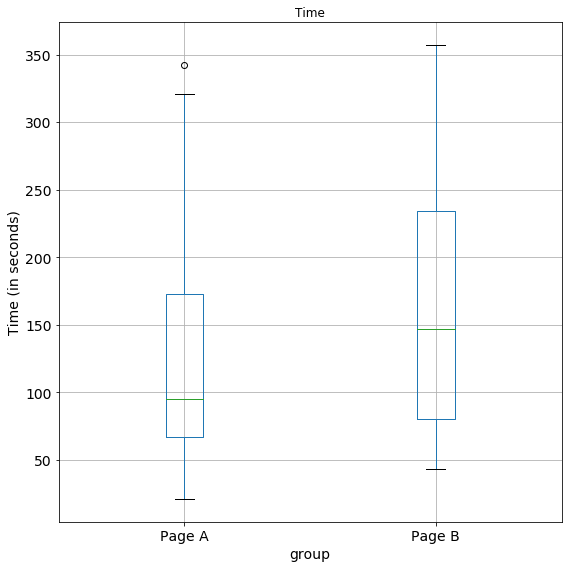

In [ ]:
ax = session_times.boxplot(by='Page', column='Time',figsize=(8, 8), fontsize=14)
ax.set_xlabel('group', fontsize=14)
ax.set_ylabel('Time (in seconds)', fontsize=14)
plt.suptitle('')
plt.tight_layout()

plt.show()

In [ ]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()

print(mean_b - mean_a)

35.66666666666667


In [ ]:
# Permutation test example with stickiness
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()
    
nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(perm_fun(session_times.Time, nA, nB))

-49.36190476190475


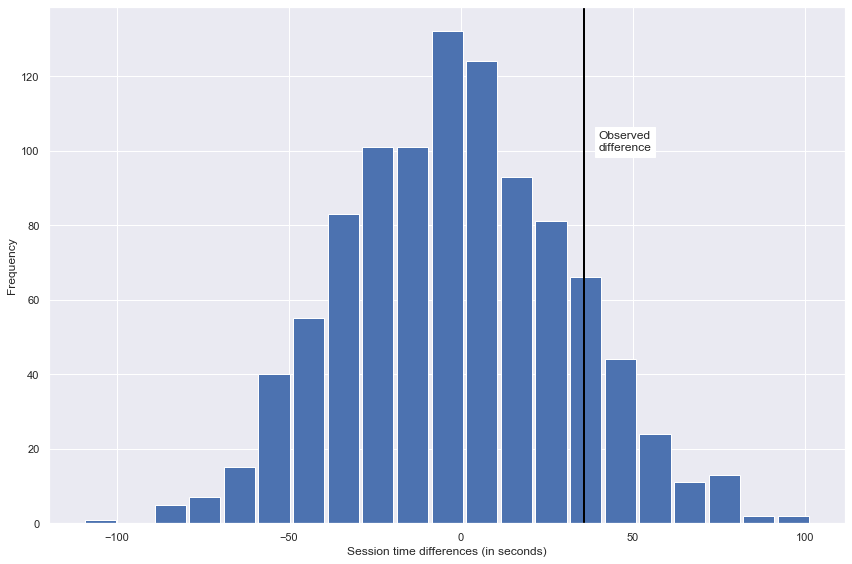

In [ ]:
## random.seed(1)
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(perm_diffs, bins=21, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
ax.text(40, 100, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
print(np.mean(perm_diffs > mean_b - mean_a))

0.135


## 순열검정: 데이터 과학에서의 결론
- 검정 통계 값이 유의미한지 알아보기 위해 사용하는 휴리스틱 방법이다.
- 각 그룹의 샘플 크기는 달라도 되며, 각 그룹의 분포가 정규분포를 따라야한다는 가정도 필요 없다.
- 하지만 어떤 유의수준 이상으로 '유의미하다' 라는 기준이 없는 애매한 방법이므로 아래에 나올 p-value를 사용하게 된다.

# 통계적 유의성과 p-value
- p-value: 대립가설을 기각하고 귀무가설을 채택하는 실수를 범할 확률
- alpha: 실험 결과가 통계적으로 의미 있다고 간주하기 위한 임계 확률
- type 1 error: 우연에 의한 효과가 실제 효과라고 잘못 내리는 결론
- type 2 error: 실제 효과를 우연에 의한 효과라고 잘못 내리는 결론
---
- 통계적 유의성이란 어떤 실험의 결과가 우연에 의한 것인지 아니면 극단적인 것인지를 판단하는 방법이다.
- 결과가 우연히 벌어질 수 있는 분포 바같에 존재한다면 이것을 통계적으로 유의미하다고 말한다.
- 즉, 관찰된 효과가 귀무가설 모형에 대한 무작위 변위의 범위 내에 있는지 결정하는 데 사용된다.

Observed difference: 0.0368%


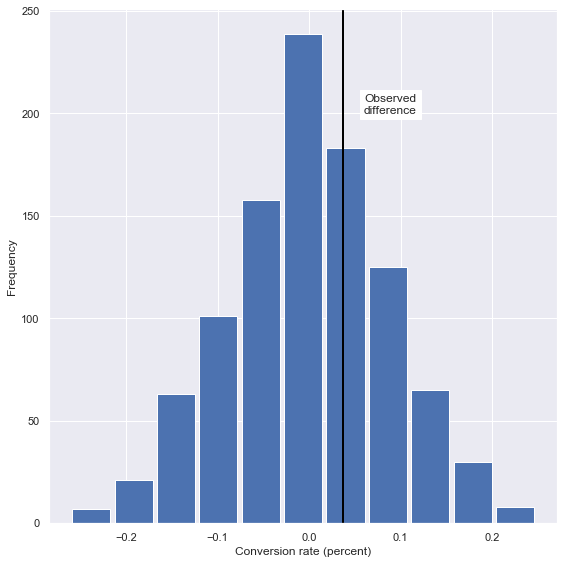

In [ ]:
random.seed(1)
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')
conversion = np.zeros(45945).tolist() # conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(8, 8))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## p-value
- **확률모형이 관측된 결과보다 더 극단적인 결과를 생성하는 빈도**를 의미한다.
- 위의 예시의 경우, 1000번 시행했을 때 원래 차이 값 보다 큰 경우가 33.2% 나 발견된 셈이다.
- 즉, 30% 정도의 확률로 우연히 발견될 수 있으니 원래의 평균 차이가 그닥 특별한 차이라고는 보기가 어려운 것이다.
- 이와 같이 p-value는 통계적 유의성을 정확히 측정하기 위한 지표가 된다.
---
p 값의 의미?
> 결과가 우연에서 비롯될 확률 (랜덤 모델이 주어졌을 때, 그 결과가 관찰된 결과 보다 더 극단적일 확률)

In [ ]:
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.332


- 사실 위의 예시의 가설은 이항분포를 따르기 때문에 굳이 순열검정을 할 필요가 없다.
- 정규분포를 사용하여 p 값을 근사시킬 수 있기 때문이다.

In [ ]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
survivors

array([[  200, 23539],
       [  182, 22406]])

In [ ]:
stats.chi2_contingency(survivors)

(0.14893055235461503,
 0.6995594627146615,
 1,
 array([[  195.74541844, 23543.25458156],
        [  186.25458156, 22401.74541844]]))

In [ ]:
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


- 이항분포를 활용하여 p값 구하기

In [ ]:
def combination(n, m):
  if n>0 and m==0 and n>m:
    return 1
  elif n>0 and m>0 and n>m:
    n_fac, m_fac, n_m_fac = 1, 1, 1
    for i in range(1, n+1):
      n_fac *= i
    for j in range(1, m+1):
      m_fac *= j
    for k in range(1, n-m+1):
      n_m_fac *= k
    return n_fac / (m_fac * n_m_fac)
  elif n>0 and m>=0 and n==m:
    return 1
  else:
    raise ValueError("'m' must be less then 'n' or equals to 'n'!!")
    
def binomial(n, m, p):
  return combination(n=n, m=m) * (p**m) * ((1-p)**(n-m))

In [ ]:
p = 200/23739
n = 100
x = [binomial(n, i, p) for i in range(n)]

## 유의수준
- 많이 사용되는 유의수준은 5%와 1%이다. 이 값은 임의로 선택된다. 올바른 x%를 보장하는 프로세스는 현재 없다.
- 이는 확률 문제가 '우연히 일어날 확률은 무엇인가?'가 아니라 '랜덤 모델이 주어졌을 때, 극단적인 결과가 나올 확률은 어느 정도인가?'이기 때문이다.

## 제 1종과 2종 오류
<img src="../image/test_errors.png" align="left">

## 데이터 과학과 p-value
- p-value는 유용한 모델의 결과가 일반적인 랜덤 변이 범위 내에 있는지를 알고 있을 때 유용한 측정 지표이다.
- p-value를 모든 실험에서 의사 결정을 좌우하는 도구로서 간주해서는 안 된다. 어떤 결정에 관련된 정보의 일부일 뿐이다.
- 예를 들어, p-value에 따라 변수를 모델에 포함하거나 제외하기도 한다.

# t-test
- 두 집단이 같냐 다르냐를 판별하기 위한 테스트임!
- **두 집단간 평균을 비교**하는 **모수적** 통계 방법으로서 표본이 정규성, 등분산성, 독립성 등을 만족할 경우 적용이 가능함.
  - 모수적 방법: 모집단의 특성을 가정하여 유도된 검정법
  - 비모수적 방법: 모집단의 모수에 대한 가정 없이 유도된 검정법
- one sample t-test
- two samples t-test
- paired t-test
---
- T-Distribution: 정규분포의 특징으로 평균을 추정하기 위해 사용되는 분포이다.
- 모집단이 정규분포라는 정도만 알고 있고 모분산을 모를 때 표본분산으로 대체하여 모평균을 추정할때 사용한다.
- 즉, 적은 표본으로 모집단의 평균을 추정하기 위해 사용되는 확률분포이다.
---

<img src="../image/t-value_formula.png" align="left">  
→ 두 집단의 평균적인 편차가 우리가 일반적으로 1표준편차라 부르는 딱히 큰 의미가 없는 구간 보다 멀리 존재해야 의미있는 차이라 부를 수 있을 것이다.  
→ 즉, 분자의 차이가 분모에 해당하는 표준편차 보다도 못 하다면 큰 의미가 있다고 보기 어렵다고 해석할 수 있다.  
  
<img src="../image/t-value_formula_2.png" align="left">

<img src="../image/t-value.png" align="left">  

In [ ]:
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time, 
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.1408


In [ ]:
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times[session_times.Page == 'Page A'].Time, 
    session_times[session_times.Page == 'Page B'].Time,
    usevar='unequal', alternative='smaller')
print(f'p-value: {pvalue:.4f}')

p-value: 0.1408


---
- 부트스트랩을 이용하여 t-test 진행

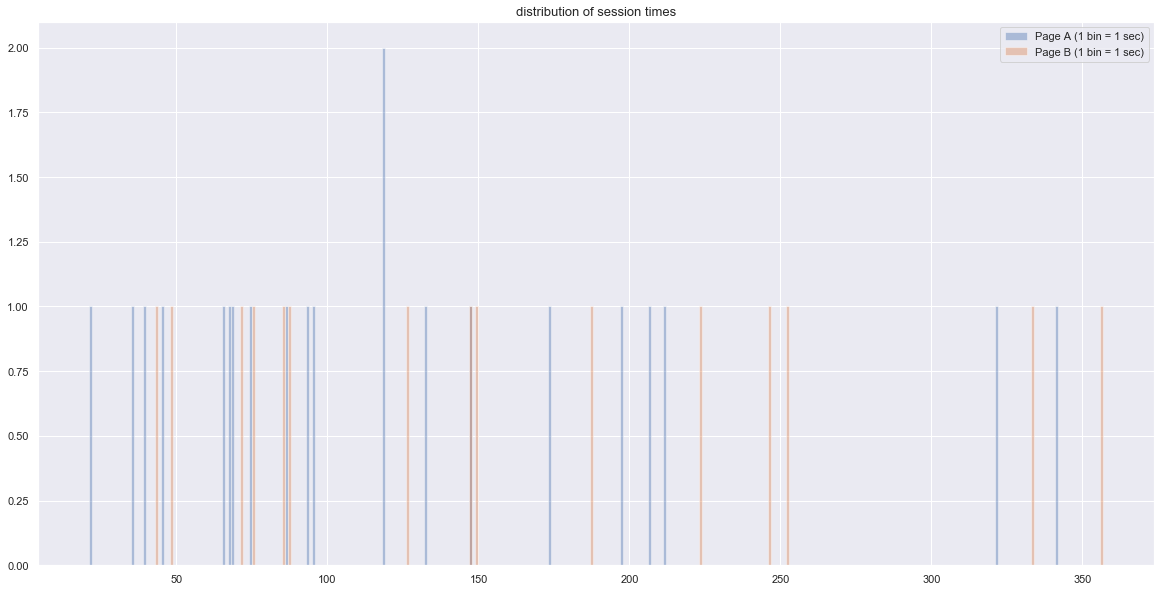

In [ ]:
plot_dist(x=session_times[session_times.Page=='Page A'].Time, bins=1, label='Page A (1 bin = 1 sec)')
plot_dist(x=session_times[session_times.Page=='Page B'].Time, bins=1, label='Page B (1 bin = 1 sec)')
plt.title('distribution of session times', fontsize=13)
plt.legend();

In [ ]:
from sklearn.utils import resample
n = 1000
A = [resample(session_times[session_times.Page == 'Page A'].Time, n_samples=30).values.mean() for _ in range(n)]
B = [resample(session_times[session_times.Page == 'Page B'].Time, n_samples=30).values.mean() for _ in range(n)]

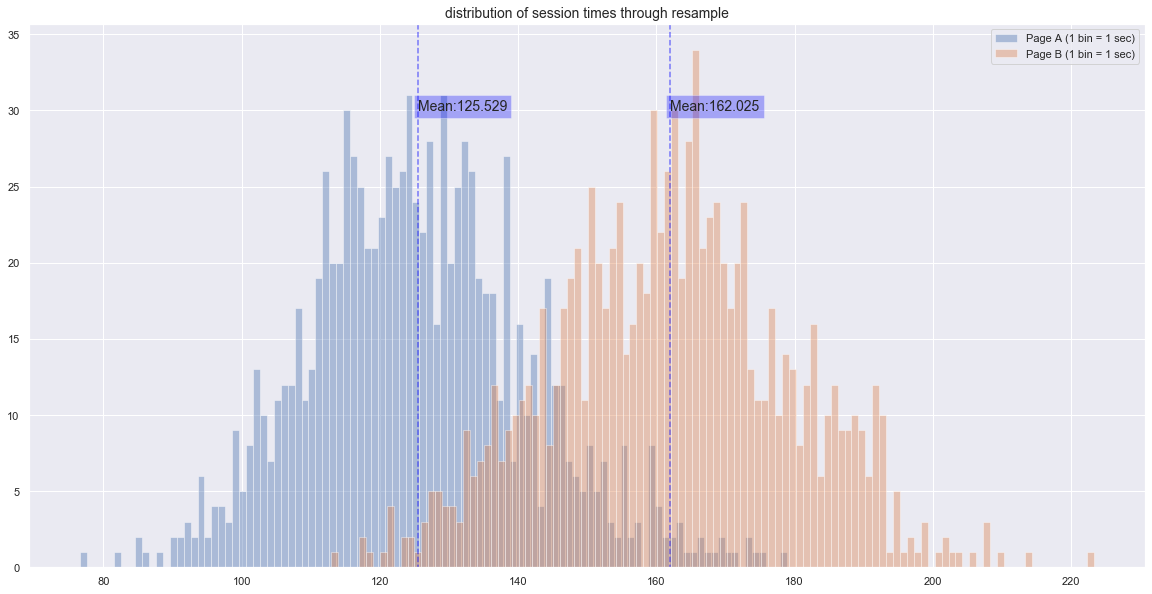

In [ ]:
plot_dist(A, bins=1, label='Page A (1 bin = 1 sec)', line_mean=30)
plot_dist(B, bins=1, label='Page B (1 bin = 1 sec)', line_mean=30)
plt.title('distribution of session times through resample', fontsize=14)
plt.legend();

In [ ]:
def variance(a, b):
  x, y = np.asarray(a), np.asarray(b)
  
  dev_x = x - np.mean(x)
  dev_sqr_sum_a = sum(dev_x**2)
  
  dev_y = y - np.mean(y)
  dev_sqr_sum_b = sum(dev_y**2)
  
  return (dev_sqr_sum_a + dev_sqr_sum_b) / (len(a) + len(b) - 2)

In [ ]:
s2 = variance(A, B)
na = len(A)
nb = len(B)

t_value = (np.mean(A) - np.mean(B)) / np.sqrt((s2/na) + (s2/nb))
t_value = round(t_value, 4)
t_value

-49.2318

In [ ]:
alpha = 0.025
cv = stats.t.ppf(1-alpha, df=1000)
cv = round(cv, 4)
cv

1.9623

In [ ]:
if t_value >= 0 and np.abs(t_value) >= cv:
  print('t-value는 {}이고 Critical Value는 {}이므로 Page B의 Session이 Page A 보다 높다고 볼 수 있다.'.format(t_value, cv))
elif t_value < 0 and np.abs(t_value) < cv:
  print('t-value는 {}이고 Critical Value는 -{}이므로 Page B의 Session이 Page A 보다 높다고 볼 수 없다.'.format(t_value, cv))
elif t_value < 0 and np.abs(t_value) > cv:
  print('t-value는 {}이고 Critical Value는 -{}이므로 Page B의 Session이 Page A 보다 높다고 볼 수 있다.'.format(t_value, cv))

t-value는 -49.2318이고 Critical Value는 -1.9623이므로 Page B의 Session이 Page A 보다 높다고 볼 수 있다.


In [ ]:
stats.ttest_ind(A, B, equal_var=False)

Ttest_indResult(statistic=-49.231802400538484, pvalue=0.0)

## one-sample 정규성 검정

In [ ]:
from scipy.stats import ttest_1samp
data = [ 32, 34 , 29 , 29 , 22 , 39, 38 , 37 , 38 , 36 , 30, 26 , 22 , 22]
expected_mean = 30
tstat, pvalue = ttest_1samp(data, expected_mean)
print(f'tstat: {tstat:.4f}')
print(f'p-value: {pvalue:.4f}')

tstat: 0.5974
p-value: 0.5605


## two-sample의 등분산 검정
- bartlett, fligner, levene

# 다중검정
- 다양한 변수로부터 모델링을 하게 될 경우 특정 변수는 실제 예측력에 큰 영향을 끼치지 못하지만, 마치 그렇게 보여지는 현상이 나타나는 '오버피팅'이 발생한다.

# 자유도
- t-tset에서 자유도(degree of freedom)는 표본의 크기가 커지면 커질수록 자유도가 커지고, 자유도가 커졌다는 의미는 데이터가 t-분포에 묶여있다가 자유롭게 표준정규분포를 사용할 수 있음을 의미한다.
- 흔히 공식에서 표준편차를 (n-1)^1/2로 나누어주는데, 그 이유가 데이터가 적을수록 편차의 편향이 커질 수 있다는 점을 감안하기 위한 것이다.
- 그렇다면 데이터 과학에서도 이것이 반드시 중요할까? 꼭 그렇진 않다. 일반적으로 요즘의 데이터 크기는 충분하기 때문에 n, n-1을 굳이 구별하며 계산할 필요는 없다.
- 단, 회귀를 할 때 다중공선성을 피하기 위해 범주형 변수들을 n-1개의 지표 혹은 더미 변수로 사용하는 것이 필요하다.

# 분산분석
- pairwise comparsion: 여러 그룹 중 두 그룹 간의 가설검정
- omnibus test: 여러 그룹 평균들의 전체 분산에 관한 단일 가설검정
- decomposition of variance: 분산분해
- F-statistic
- SS(sum of square)
---
- 세 개 이상의 집단 간 차이를 분석할 때 사용하는 것이 ANOVA(Analysis of variance) 분석이다.
- 분산분석도 처음에는 순열검정을 기반으로 시도한다.
  - 1. 그룹 간 평균의 분산을 구한다
  - 2. 전체 데이터를 순열로 재추출하여 각 그룹에 할당하고, 그룹 별 평균의 분산을 1회 구한다.
  - 3. 2번의 과정을 N번만큼 수행하고, 분포를 그리면 이것이 F 분포가 되는 것이며, 기존의 그룹 간 평균의 분산(MS-treatment) 보다 큰 값들의 비율을 관측한다.
- 그런데 두 집단의 T-test를 여러 번 해서 비교하면 되는 것 아닌가..?
  - 이렇게 하면 1종 오류에 빠지게 된다!
---
독립변수: 연구자/조사자가 의도적으로 변화시키는 변수 (단, 의도적으로 변화시킬 수 있다고하여 마음대로 변수를 바꿔도 된다는 것은 아님)  
종속변수: 독립변수의 변화에 따라 어떻게 변하는지 알고 싶은 변수  
통제변수: 독립변수와 동일하나 주된 관심사가 되는 변수가 아닌 경우

## One-way(일원 분산분석)

- One-way ANOVA
  - 종속변수: 연속형 변수만 가능
  - 독립변수: 이산형/범주형 변수만 가능 (* 독립변수는 반드시 1개임! 즉, 한 개의 컬럼 안에 필드 값의 종류가 여러 개 있다는 것임)
  - 예시: 신종플루 신약을 개발한 어느 제약회사에서 신종플루 감염자를 대상으로 신약의 효과를 측정하고자 할 때 새로 개발된 신약, 기존의 독감 약, 플라시보 세 개로 나누어 실험하는 것 등임

### 순열검정

In [ ]:
four_sessions = pd.read_csv('./data/four_sessions.csv')
four_sessions.head()

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172


In [ ]:
four_sessions.Page.value_counts()

Page 4    5
Page 2    5
Page 1    5
Page 3    5
Name: Page, dtype: int64

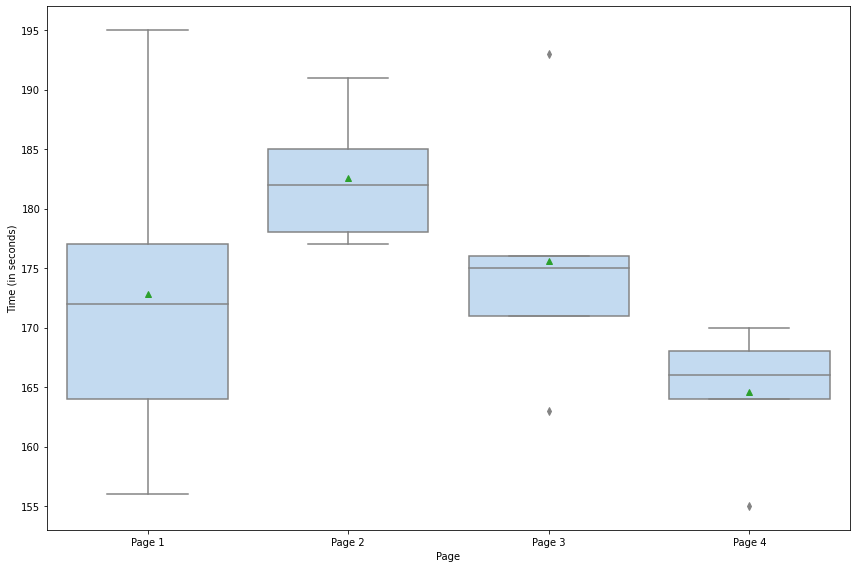

In [ ]:
plt.figure(figsize=(12,8))
ax=sns.boxplot(x='Page', y='Time', data=four_sessions, color='#BCDAF7', showmeans=True)
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')
plt.tight_layout()
plt.show()

In [ ]:
observed_variance = four_sessions.groupby('Page').mean().var(ddof=1)[0] # 여기서 var은 분모가 샘플 갯수의 n-1로 나눔. 디폴트 값인듯.
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655


In [ ]:
# 각 그룹에 기존 Time이 아닌 무작위로 새로 섞어서 핧당하고, 그룹 별 평균으로부터 분산을 구함.
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]
    
print(perm_test(four_sessions))

df_tmp = four_sessions.copy()
df_tmp['Time'] = np.random.permutation(df_tmp['Time'].values)
df_tmp.sort_values('Page').reset_index(drop=True)

0.6799999999999984


,Page,Time
0,Page 1,185
1,Page 1,170
2,Page 1,177
3,Page 1,164
4,Page 1,172
5,Page 2,171
6,Page 2,166
7,Page 2,191
8,Page 2,176
9,Page 2,177


Pr(Prob) 0.07533333333333334


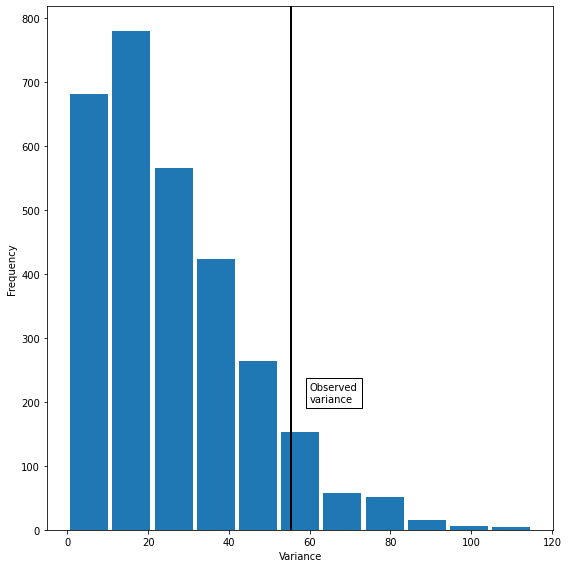

In [ ]:
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(8, 8))
ax.hist(perm_variance, bins=11, rwidth=0.9) # F 분포가 그려짐
ax.axvline(x=observed_variance, color='black', lw=2)
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'})
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## F-통계량

<img src="../image/f_value.png" align="left">

<img src="../image/f_value_2.png" align="left">  

<img src="../image/f_value_3.png" align="left">

<img src="../image/f_value_4.png" align="left">

<img src="../image/one_way_hypothesis.png" align="left">

In [ ]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()
                
aov_table = sm.stats.anova_lm(model)
print(aov_table)

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


In [ ]:
res = stats.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time, 
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)
print(f'F-Statistic: {res.statistic:.4f}')
print(f'p-value: {res.pvalue:.4f}')

F-Statistic: 2.7398
p-value: 0.0776


아래는 계산 과정을 유도한 것임

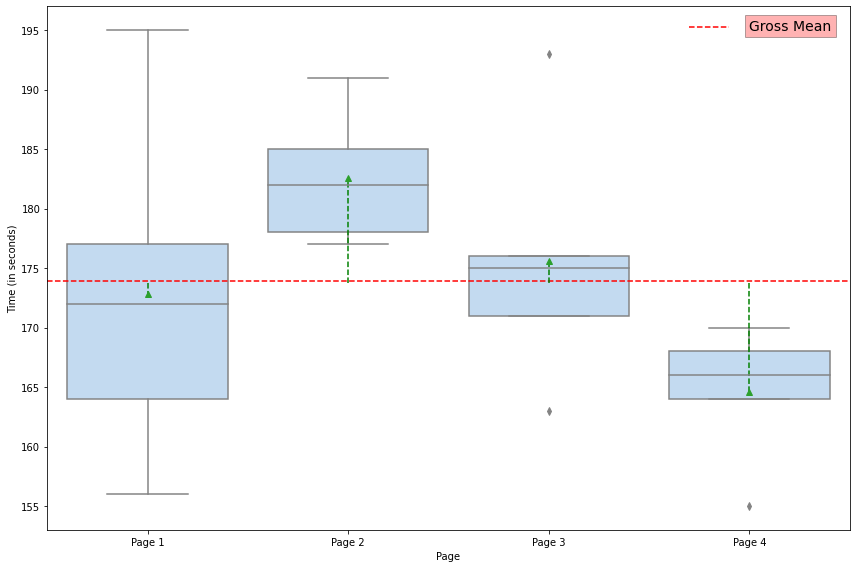

In [ ]:
gm = four_sessions.Time.mean()

plt.figure(figsize=(12,8))
ax=sns.boxplot(x='Page', y='Time', data=four_sessions, color='#BCDAF7', showmeans=True)
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')
plt.axhline(gm, 0, 1, color = 'red', ls = '--', alpha = 1)
plt.text(x=3, y=195, s="Gross Mean", bbox = dict(facecolor = 'red', alpha = 0.3), fontsize = 14)
plt.axhline(195.3, 0.8, 0.85, color = 'red', ls = '--', alpha = 1)
plt.axvline(0, 0.471, 0.445, color = 'green', ls = '--', alpha = 1)
plt.axvline(1, 0.471, 0.665, color = 'green', ls = '--', alpha = 1)
plt.axvline(2, 0.471, 0.51, color = 'green', ls = '--', alpha = 1)
plt.axvline(3, 0.471, 0.26, color = 'green', ls = '--', alpha = 1)
plt.tight_layout()
plt.show()

In [ ]:
df_tmp = four_sessions.copy()
df_tmp['gross_mean'] = df_tmp.Time.mean()
df_tmp = pd.merge(left=df_tmp.sort_values('Page').reset_index(drop=True),
                  right=df_tmp.groupby('Page')['Time'].agg(group_mean='mean'),
                  left_on='Page',
                  right_index=True)
df_tmp['between'] = (df_tmp.group_mean - df_tmp.gross_mean)**2
df_tmp['within'] = (df_tmp.Time - df_tmp.group_mean)**2
df_tmp

,Page,Time,gross_mean,group_mean,between,within
0,Page 1,164,173.9,172.8,1.21,77.44
1,Page 1,195,173.9,172.8,1.21,492.84
2,Page 1,172,173.9,172.8,1.21,0.64
3,Page 1,156,173.9,172.8,1.21,282.24
4,Page 1,177,173.9,172.8,1.21,17.64
5,Page 2,177,173.9,182.6,75.69,31.36
6,Page 2,185,173.9,182.6,75.69,5.76
7,Page 2,182,173.9,182.6,75.69,0.36
8,Page 2,191,173.9,182.6,75.69,70.56
9,Page 2,178,173.9,182.6,75.69,21.16


In [ ]:
df_tmp = four_sessions.copy()
df_tmp['gross_mean'] = df_tmp.Time.mean()
df_tmp = pd.merge(left=df_tmp.sort_values('Page').reset_index(drop=True),
                  right=df_tmp.groupby('Page')['Time'].agg(group_mean='mean'),
                  left_on='Page',
                  right_index=True)
df_tmp['between'] = (df_tmp.group_mean - df_tmp.gross_mean)**2
df_tmp['within'] = (df_tmp.Time - df_tmp.group_mean)**2
df_tmp

In [ ]:
print("총 평균으로부터 그룹 간 평균 편차의 합계와 between 합이 같은가?")
print(round(df_tmp.group_mean.var(ddof=19), 4) == round(df_tmp.between.sum(), 4))

총 평균으로부터 그룹 간 평균 편차의 합계와 between 합이 같은가?
True


In [ ]:
print("sum_sq(Page): {}".format(df_tmp.between.sum()))
print("sum_sq(Residual): {}".format(df_tmp.within.sum()))

sum_sq(Page): 831.3999999999999
sum_sq(Residual): 1618.3999999999999


In [ ]:
between_variance = df_tmp.between.sum() / (4 - 1)
within_variance = df_tmp.within.sum() / (20 - 4)

f_value = round(between_variance / within_variance, 4)
print("F-value: {}".format(f_value))

F-value: 2.7398


## Two-way(이원 분산분석)

- 이원 분산분석은 일원 자체가 하나의 그룹이 되는 ANOVA이다.
- 즉, 주말 vs. 평일을 비교하는 것 처럼 그룹 A 주말, 그룹 A 평일, 그룹 B 주말 등으로 나누는 것이다.
- 이처럼 여러 요인과 그 효과를 모델링할 수 있는 회귀와 로지스틱 회귀 같은 완전한 통계 모델을 위한 첫걸음이 바로 이 ANOVA, 특히 이원 ANOVA라고 할 수 있다.

# 카이제곱검정
- 독립변수와 종속변수가 모두 범주형 변수일 때 사용한다.
- 목적은 두 가지인데,
  - 변수가 한 개인 경우: 변수 내 그룹간의 비율이 같은지 다른지(단, 그룹이 2개인 경우 Binomial test, **그룹이 여러 개면 카이제곱 검정**)
  - 변수가 두 개인 경우: 변수 사이의 연관성(Association)이 있는지 없는지 (e.g 휴대폰 사용과 뇌암, 인종과 특정 질병 등)

## 일원 카이제곱 검정

<img src="../image/chi_1.png" align="left">

<img src="../image/chi_2.png" align="left">  

<img src="../image/chi_3.png" align="left">  

<img src="../image/chi_4.png" align="left">

<img src="../image/chi_5.png" align="left">

<img src="../image/chi_6.png" align="left">

## 이원 카이제곱 검정

<img src="../image/chi_two_way_1.png" align="left">  

<img src="../image/chi_two_way_2.png" align="left">  

<img src="../image/chi_two_way_3.png" align="left">

<img src="../image/chi_two_way_4.png" align="left">  

<img src="../image/chi_two_way_5.png" align="left">  

<img src="../image/chi_two_way_6.png" align="left">  

<img src="../image/chi_two_way_7.png" align="left">  

<img src="../image/chi_two_way_8.png" align="left"> 

<img src="../image/chi_two_way_9.png" align="left">  

## 재표본추출 방법
- 이원 카이제곱 검정

In [ ]:
# Table 3-4
click_rate = pd.read_csv('./data/click_rates.csv')
click_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
Headline    6 non-null object
Click       6 non-null object
Rate        6 non-null int64
dtypes: int64(1), object(2)
memory usage: 272.0+ bytes


In [ ]:
click_rate.head()

,Headline,Click,Rate
0,Headline A,Click,14
1,Headline A,No-click,986
2,Headline B,Click,8
3,Headline B,No-click,992
4,Headline C,Click,12


In [ ]:
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
clicks

Headline,Headline A,Headline B,Headline C
Click,,,
Click,14,8,12
No-click,986,992,988


In [ ]:
# Table 3-5
row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})

,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


In [ ]:
# Resampling approach
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [34 / 3, 1000 - 34 / 3]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4805


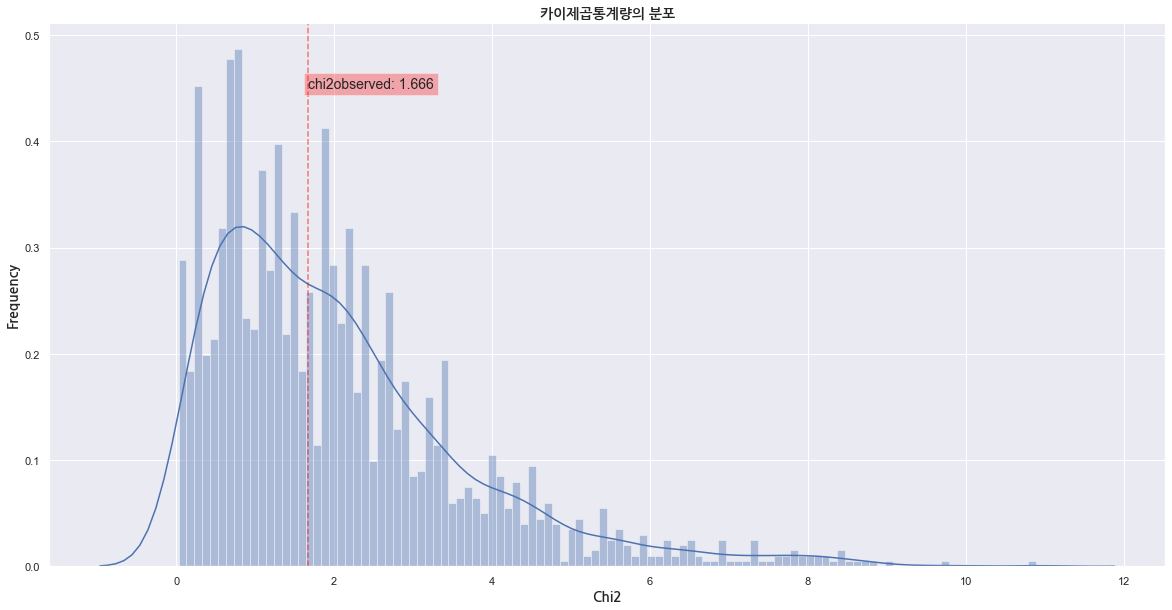

In [ ]:
plot_dist(x=perm_chi2, bins=10, kde=True, label='distribution of perm_chi2')
plot_title(title="카이제곱통계량의 분포", xlabel="Chi2", ylabel="Frequency", fontproperties=fontprop, fontsize=14)
plt.axvline(chi2observed, 0, 1, color = 'red', ls = '--', alpha = 0.5)
plt.text(x=chi2observed, y=0.45, s = "chi2observed: " + str(round(chi2observed, 3)), bbox=dict(facecolor='red', alpha=0.3), fontsize=14);

In [ ]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6659
p-value: 0.4348


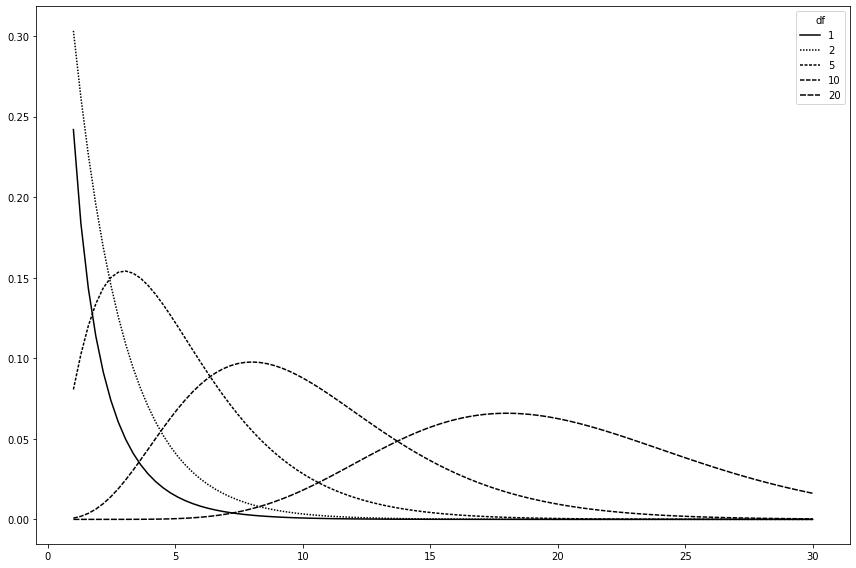

In [ ]:
x = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pd.DataFrame({
    'x': x,
    'chi_1': stats.chi2.pdf(x, df=1),
    'chi_2': stats.chi2.pdf(x, df=2),
    'chi_5': stats.chi2.pdf(x, df=5),
    'chi_10': stats.chi2.pdf(x, df=10),
    'chi_20': stats.chi2.pdf(x, df=20),
})
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(chi.x, chi.chi_1, color='black', linestyle='-', label='1')
ax.plot(chi.x, chi.chi_2, color='black', linestyle=(0, (1, 1)), label='2')
ax.plot(chi.x, chi.chi_5, color='black', linestyle=(0, (2, 1)), label='5')
ax.plot(chi.x, chi.chi_10, color='black', linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='black', linestyle=(0, (4, 1)), label='20')
ax.legend(title='df')

plt.tight_layout()
plt.show()

## 피셔의 정확검정
- 카이제곱 검정의 재표본을 활용한 방법을 한 번에 알 수 있는 방법이다.
- 단, 기대값이 5 이상은 되었을 때만 사용이 가능하다.

In [ ]:
stats.fisher_exact(clicks.values)

ValueError: The input `table` must be of shape (2, 2).

# 검정력과 표본크기

In [ ]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 116602.393


In [ ]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 5488.408
